# Chron.jl age-depth example using radiocarbon data

This Jupyter notebook demonstrates an example age-depth model using [Chron.jl](https://github.com/brenhinkeller/Chron.jl). For more information, see [github.com/brenhinkeller/Chron.jl](https://github.com/brenhinkeller/Chron.jl) and [doi.org/10.17605/osf.io/TQX3F](https://doi.org/10.17605/osf.io/TQX3F)

Any code from this notebook can also be copied and pasted into the Julia REPL or a .jl script

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file
***

## Load required Julia packages

In [1]:
# Load (and install if necessary) the Chron.jl package
try
    using Chron
catch
    Pkg.clone("https://github.com/brenhinkeller/Chron.jl")
    using Chron
end

using Statistics, StatsBase, SpecialFunctions
using Plots; gr();

***
## Enter sample information
Paste your data in here!

In [2]:
# Input the number of samples we wish to model (must match below)
nSamples = 4

# Make an instance of a ChronSection object for nSamples
smpl = NewChronAgeData(nSamples)
smpl.Name          = ("Sample 1", "Sample 2", "Sample 3", "Sample 4") # Et cetera
smpl.Age           = [ 6991,  7088,  7230,  7540,] # Measured ages
smpl.Age_sigma     = [   30,    70,    50,    50,] # Measured 1-σ uncertainties
smpl.Height[:]     = [ -355,  -380,-397.0,-411.5,] # Depths below surface should be negative
smpl.Height_sigma[:]  = fill(0.01, nSamples) # Usually assume little or no sample height uncertainty
smpl.Age_Sidedness[:] = zeros(nSamples) # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided

smpl.Age_Unit = "ka"; # Unit of measurement for ages
smpl.Height_Unit = "m"; # Unit of measurement for Height and Height_sigma

***
## Configure and run stratigraphic model
note: to spare Binder's servers, this demo uses
```
config.nsteps = 3000 
config.burnin = 2000*npoints_approx
```
However, you probably want higher numbers for a publication-quality result, for instance 
```
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
```
and examine the log likelihood plot to make sure you've converged.

To run the stratigraphic MCMC model, we call the `StratMetropolis14C` function. If you're not using radiocarbon ages and want to run stratigraphic model with Gaussian mean age and standard deviation for some number of stratigraphic horizons, then you can set `smpl.Age` and `smpl.Age_sigma` directly, but then you'll need to call `StratMetropolis` instead of `StratMetropolis14C`

Generating stratigraphic age-depth model...
Burn-in: 3400000 steps


Burn-in...100%|█████████████████████████████████████████| Time: 0:01:48


Collecting...100%|██████████████████████████████████████| Time: 0:04:57


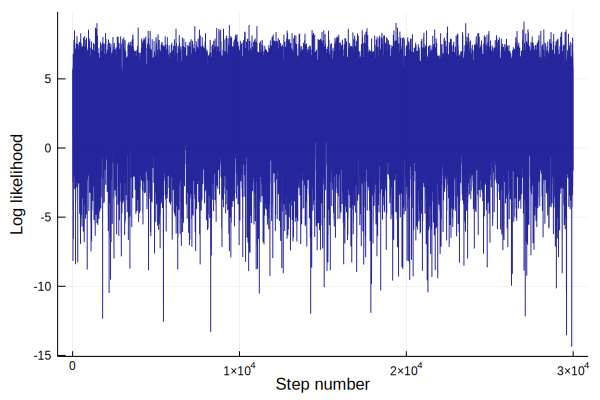

In [3]:
# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If in doubt, you can probably leave these parameters as-is
config.resolution = 0.2 # Same units as sample height. Smaller is slower!
config.bounding = 0.1 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolis(smpl, config)

# Plot the log likelihood to make sure we're converged (n.b burnin isn't recorded)
plot(lldist,xlabel="Step number",ylabel="Log likelihood",label="",line=(0.85,:darkblue))

***
## Plot results

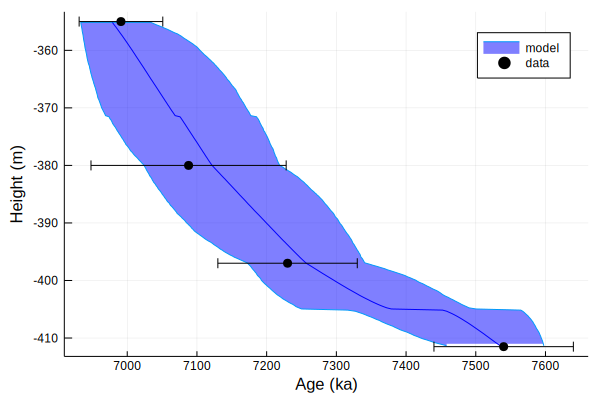

In [10]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(round(Int,minimum(mdl.Height)),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="")
plot!(hdl, smpl.Age, smpl.Height, xerror=smpl.Age_sigma*2,label="data",seriestype=:scatter,color=:black)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")
savefig(hdl,"AgeDepthModel.pdf");
display(hdl)

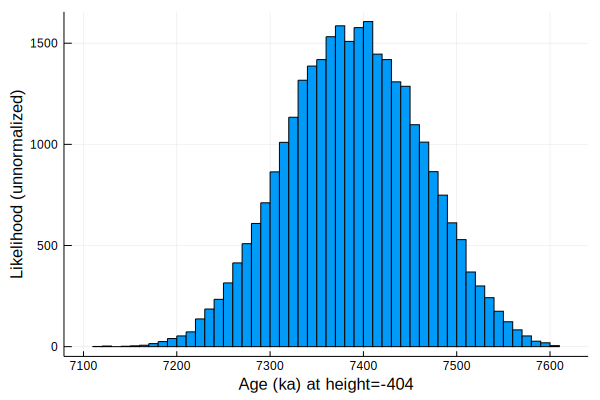

Interpolated age at height=-404: 7389.302706203987 +140.2605837680985/-140.5277609033692 ka

In [5]:
# Stratigraphic height at which to interpolate
height = -404

age_at_height = linterp1s(mdl.Height,mdl.Age,height)
age_at_height_min = linterp1s(mdl.Height,mdl.Age_025CI,height)
age_at_height_max = linterp1s(mdl.Height,mdl.Age_975CI,height)
print("Interpolated age at height=$height: $age_at_height +$(age_at_height_max-age_at_height)/-$(age_at_height-age_at_height_min) $(smpl.Age_Unit)")

# Optional: interpolate full age distribution
interpolated_distribution = Array{Float64}(undef,size(agedist,2))
for i=1:size(agedist,2)
    interpolated_distribution[i] = linterp1s(mdl.Height,agedist[:,i],height)
end
hdl = histogram(interpolated_distribution, nbins=50, label="")
plot!(hdl, xlabel="Age ($(smpl.Age_Unit)) at height=$height", ylabel="Likelihood (unnormalized)")
savefig(hdl, "Interpolated age distribution.pdf")
display(hdl)

There are other things we can plot as well, such as deposition rate:

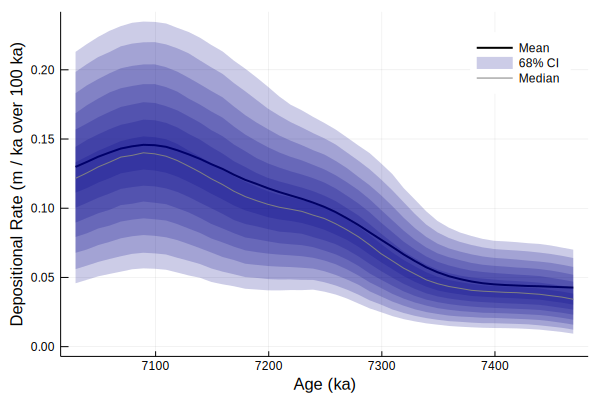

  0.545190 seconds (1.23 M allocations: 311.424 MiB, 12.64% gc time)


In [6]:
# Set bin width and spacing
binwidth = 100 # yr
binoverlap = 10
ages = collect(minimum(mdl.Age):binwidth/binoverlap:maximum(mdl.Age))
bincenters = ages[1+Int(binoverlap/2):end-Int(binoverlap/2)]
spacing = binoverlap

# Calculate rates for the stratigraphy of each markov chain step
dhdt_dist = Array{Float64}(undef, length(ages)-binoverlap, config.nsteps)
@time for i=1:config.nsteps
    heights = linterp1(reverse(agedist[:,i]), reverse(mdl.Height), ages)
    dhdt_dist[:,i] = abs.(heights[1:end-spacing] - heights[spacing+1:end]) ./ binwidth
end

# Find mean and 1-sigma (68%) CI
dhdt = nanmean(dhdt_dist,dim=2)
dhdt_50p = nanmedian(dhdt_dist,dim=2)
dhdt_16p = pctile(dhdt_dist,15.865,dim=2) # Minus 1-sigma (15.865th percentile)
dhdt_84p = pctile(dhdt_dist,84.135,dim=2) # Plus 1-sigma (84.135th percentile)
# Other confidence intervals (10:10:50)
dhdt_20p = pctile(dhdt_dist,20,dim=2)
dhdt_80p = pctile(dhdt_dist,80,dim=2)
dhdt_25p = pctile(dhdt_dist,25,dim=2)
dhdt_75p = pctile(dhdt_dist,75,dim=2)
dhdt_30p = pctile(dhdt_dist,30,dim=2)
dhdt_70p = pctile(dhdt_dist,70,dim=2)
dhdt_35p = pctile(dhdt_dist,35,dim=2)
dhdt_65p = pctile(dhdt_dist,65,dim=2)
dhdt_40p = pctile(dhdt_dist,40,dim=2)
dhdt_60p = pctile(dhdt_dist,60,dim=2)
dhdt_45p = pctile(dhdt_dist,45,dim=2)
dhdt_55p = pctile(dhdt_dist,55,dim=2)

# Plot results
hdl = plot(bincenters,dhdt, label="Mean", color=:black, linewidth=2)
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_16p; reverse(dhdt_84p)], fill=(0,0.2,:darkblue), linealpha=0, label="68% CI")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_20p; reverse(dhdt_80p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_25p; reverse(dhdt_75p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_30p; reverse(dhdt_70p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_35p; reverse(dhdt_65p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_40p; reverse(dhdt_60p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_45p; reverse(dhdt_55p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,bincenters,dhdt_50p, label="Median", color=:grey, linewidth=1)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Depositional Rate ($(smpl.Height_Unit) / $(smpl.Age_Unit) over $binwidth $(smpl.Age_Unit))", fg_color_legend=:white)
# savefig(hdl,"DepositionRateModelCI.pdf")
display(hdl)

***
## Stratigraphic model including hiatuses
We can also deal with discrete hiatuses in the stratigraphic section if we know where they are and about how long they lasted. We need some different models and methods though. In particular, in addition to the `ChronAgeData` struct, we also need a `HiatusData` struct now, and we're going to want to pass these to `StratMetropolisHiatus` instead of `StratMetropolis` like before.

Generating stratigraphic age-depth model...
Burn-in: 3400000 steps


Burn-in...100%|█████████████████████████████████████████| Time: 0:02:36


Collecting...100%|██████████████████████████████████████| Time: 0:07:39


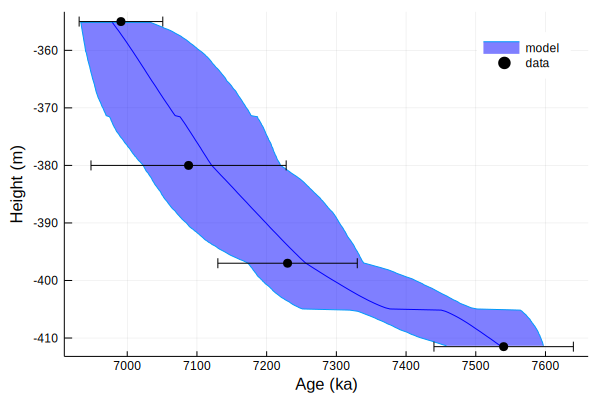

In [12]:
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
# Data about hiatuses
nHiatuses = 2 # The number of hiatuses you have data for
hiatus = NewHiatusData(nHiatuses) # Struct to hold data
hiatus.Height         = [-371.5, -405.0 ]
hiatus.Height_sigma   = [   0.0,    0.0 ]
hiatus.Duration       = [ 100.0,   123.0]
hiatus.Duration_sigma = [  30.5,    20.0]

# Run the model. Note: we're using `StratMetropolisHiatus` now, instead of just `StratMetropolis`
(mdl, agedist, hiatusdist, lldist) = StratMetropolisHiatus(smpl, hiatus, config); sleep(0.5)

# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(minimum(mdl.Height),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="", fg_color_legend=:white)
plot!(hdl, smpl.Age, smpl.Height, xerror=smpl.Age_sigma*2,label="data",seriestype=:scatter,color=:black)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")

***
[![DOI](https://raw.githubusercontent.com/brenhinkeller/Chron.jl/master/readme_figures/osf_io_TQX3F.svg?sanitize=true)](https://doi.org/10.17605/osf.io/TQX3F) 